## Анализ проведенного АБ теста в мобильном приложении

Данные были взяты из kaggle, давайте разберем результаты аб теста и проверим целесообразность внедрения нового вида платной подписки, с изменением цены

### Подготовка и предобработка данных

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro , levene, mannwhitneyu, ttest_ind

In [36]:
df = pd.read_csv('/Users/max/Desktop/NumPy_project/AB_Test_Results.csv')

In [37]:
df.head(5)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Описание данных :

* user_id - идентификационный номер пользователя

* variant_name - принадлежность к группе, контрольной или вариативной

* revenue - выручка

In [39]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [40]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [41]:
df.columns = df.columns.str.lower()

Необходимо проверить не попали ли идентичные пользователи в разные группы, их необходимо будет исключить.

In [42]:
users_control = df.query('variant_name == "control"')['user_id'].count()
users_variant = df.query('variant_name == "variant"')['user_id'].count()

print('Пользователей в группе control:', users_control)
print('Пользователей в группе variant:', users_variant)

Пользователей в группе control: 4984
Пользователей в группе variant: 5016


In [ ]:
users_unique_control = df[df['variant_name'] == 'control']['user_id']
users_unique_variant = df[df['variant_name'] == 'variant']['user_id']

users_A_B = df[df['user_id'].isin(users_unique_control) & df['user_id'].isin(users_unique_variant)]['user_id'].unique()

print(f'Количество пользователей, попавших в обе группы: {len(users_A_B)}')

Количество пользователей, попавших в обе группы: 1541


Мы зафиксировали значительное количество пользователей, исключаем их из данных для корректности результатов

In [44]:
df= df.loc[~df['user_id'].isin(users_A_B)]

### Анализ выручки по группам

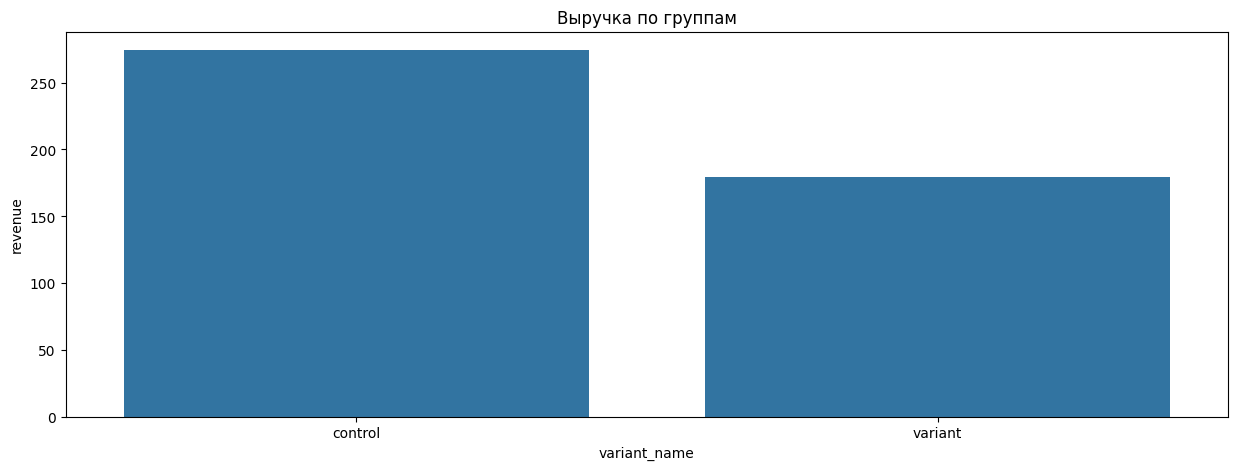

In [ ]:
aggregated_data = df.groupby('variant_name', as_index=False)['revenue'].sum()

plt.figure(figsize=(15, 5))
sns.barplot(data=aggregated_data, x='variant_name', y='revenue')
plt.title('Выручка по группам')
plt.show()

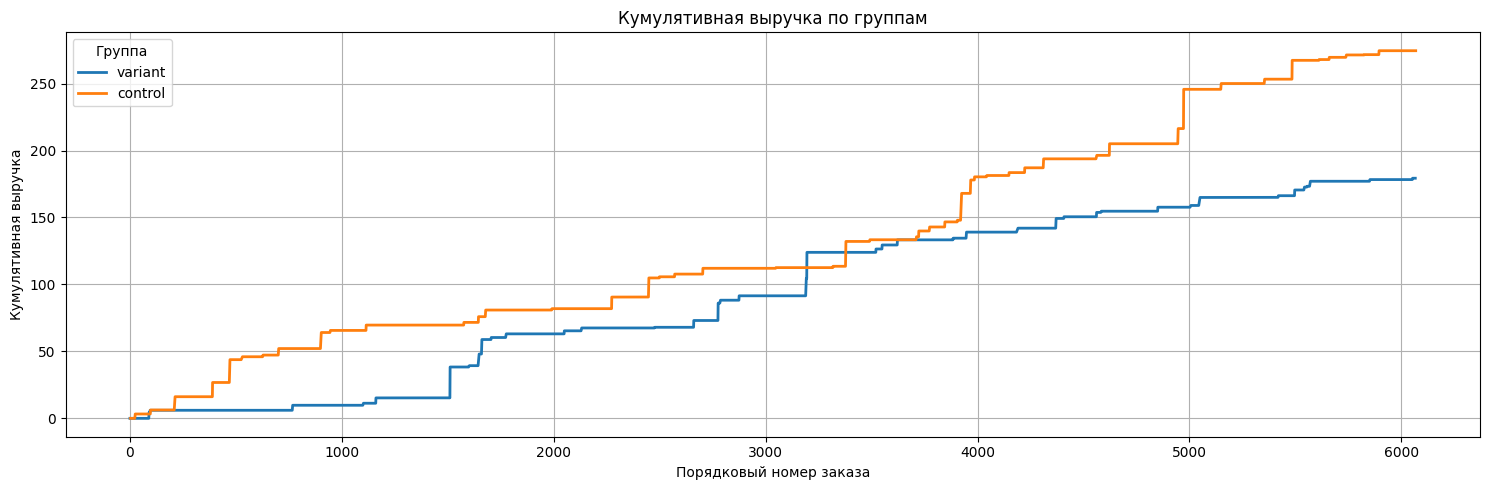

In [ ]:
ig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
    data=df, 
    x=range(len(df)),  
    y=df.groupby('variant_name')['revenue'].cumsum(),  
    hue='variant_name', 
    linewidth=2
)

plt.title('Кумулятивная выручка по группам')
plt.xlabel('Порядковый номер заказа')
plt.ylabel('Кумулятивная выручка')
plt.legend(title='Группа')
plt.grid()
plt.tight_layout() 
plt.show()

Ближе к 1000 наблюдению, есть резкий скачок в кумулятивной выручке у контрольной группы, возможно это связано с очень значительной покупкой

<Axes: xlabel='variant_name', ylabel='revenue'>

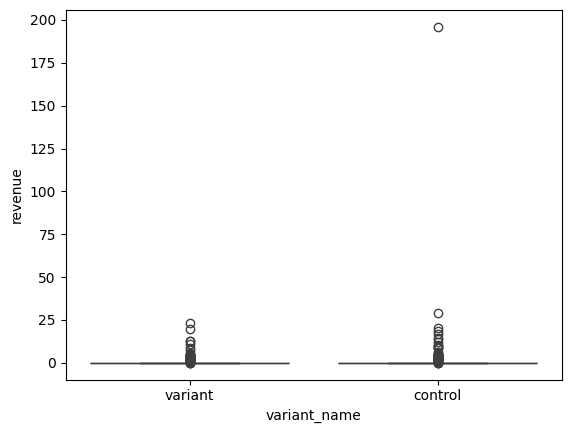

In [ ]:
sns.boxplot(x='variant_name', y='revenue', data=df)

Как видим есть выброс в данных, лучше убрать его, так как вывод может быть некорректным при его наличии

In [47]:
df.sort_values(by='revenue', ascending=False).head(5)

,user_id,variant_name,revenue
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47


In [48]:
df = df[df['user_id'] != 3342]

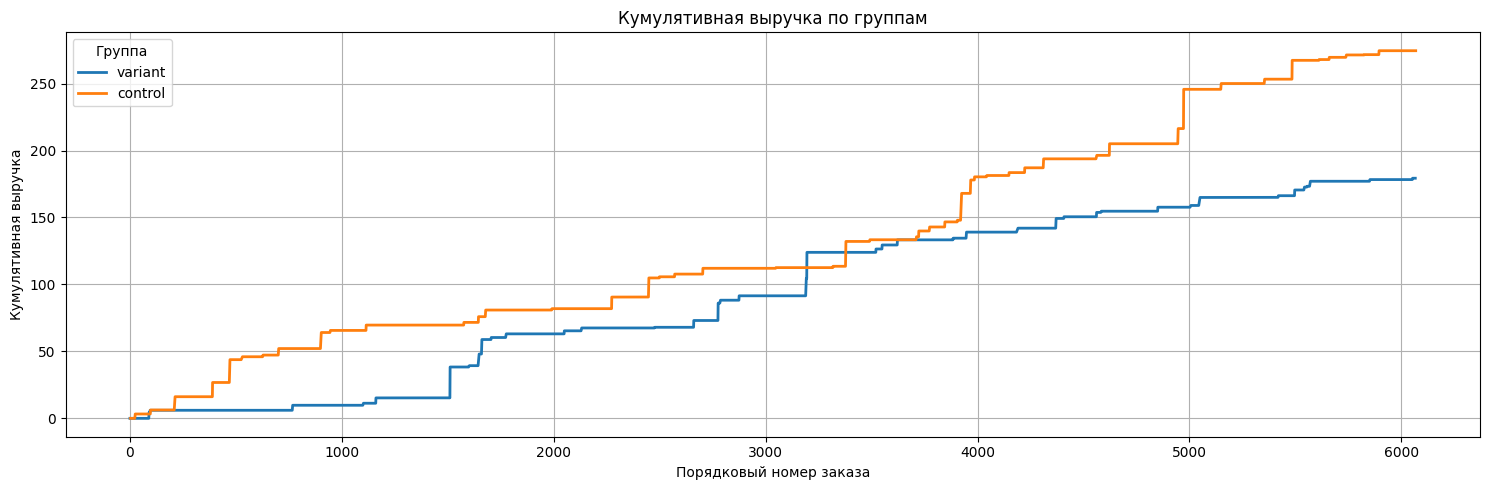

In [ ]:
ig, ax = plt.subplots(figsize=(15, 5))

sns.lineplot(
    data=df, 
    x=range(len(df)),  
    y=df.groupby('variant_name')['revenue'].cumsum(),  
    hue='variant_name', 
    linewidth=2
)

plt.title('Кумулятивная выручка по группам')
plt.xlabel('Порядковый номер заказа')
plt.ylabel('Кумулятивная выручка')
plt.legend(title='Группа')
plt.grid()
plt.tight_layout() 
plt.show()


<Axes: xlabel='variant_name', ylabel='revenue'>

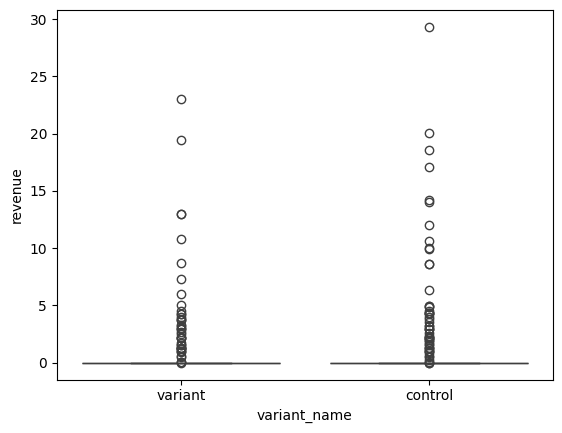

In [ ]:
sns.boxplot(x='variant_name', y='revenue', data=df)

### Проверка данных на нормальность и выбор статистического теста

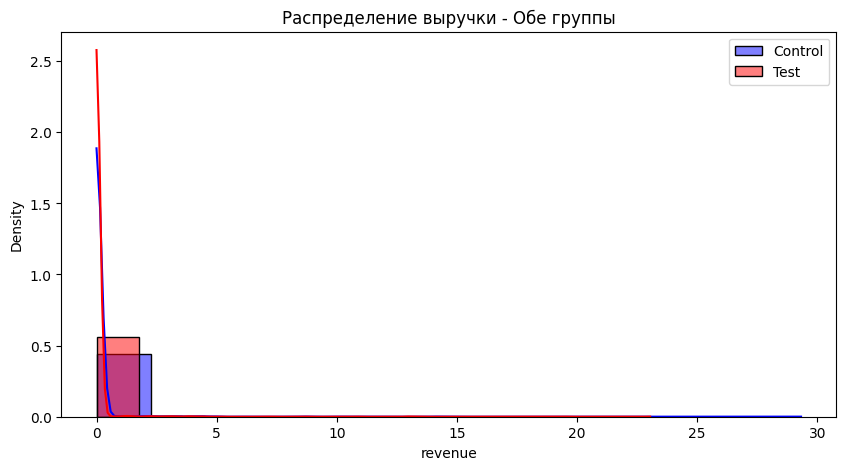

In [ ]:
control = df[df['variant_name'] == 'control']
test = df[df['variant_name'] == 'variant']

plt.figure(figsize=(10,5))
sns.histplot(control['revenue'], kde=True, color='blue', label='Control', stat='density')
sns.histplot(test['revenue'], kde=True, color='red', label='Test', stat='density')

plt.title('Распределение выручки - Обе группы')
plt.legend()
plt.show()

((array([-3.5057242 , -3.26224881, -3.12762106, ...,  3.12762106,
          3.26224881,  3.5057242 ]),
  array([ 0.  ,  0.  ,  0.  , ..., 12.99, 19.47, 23.04])),
 (np.float64(0.16972520387809467),
  np.float64(0.05890932982917211),
  np.float64(0.22302619254730818)))

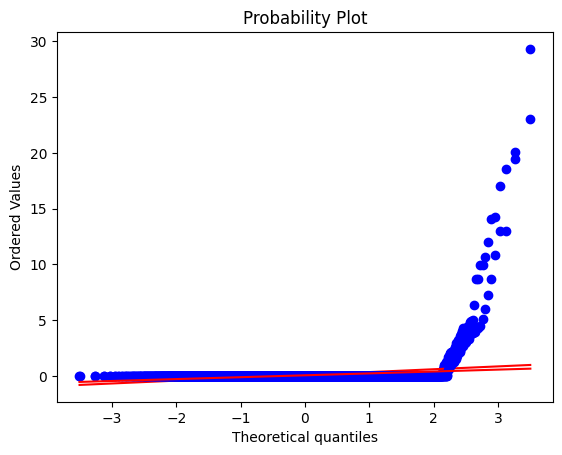

In [ ]:
stats.probplot(control['revenue'], dist="norm", plot=plt)
stats.probplot(test['revenue'], dist="norm", plot=plt)

Как мы видим на гистограмме и qq plot, данные не распределяются нормально. Сделаем контрольную проверку с помощью теста Шапиро-Уилка

In [ ]:
stat, p = shapiro(control['revenue'])
print(f'Statistics={stat}, p-value={p}')

if p < 0.05:
    print('Данные НЕ распределены нормально')
else:
    print('Данные распределены нормально')

Statistics=0.062157467035860337, p-value=2.083866443535456e-81
Данные НЕ распределены нормально


In [ ]:
stat, p = shapiro(test['revenue'])
print(f'Statistics={stat}, p-value={p}')

if p < 0.05:
    print('Данные НЕ распределены нормально')
else:
    print('Данные распределены нормально')

Statistics=0.051010585813946685, p-value=8.125449426822169e-82
Данные НЕ распределены нормально


Так как данные распределены не нормально, используем тест Манна-Уитни для принятия финального решения по внедрению аб теста

In [56]:
stat, p = stats.mannwhitneyu(control['revenue'], test['revenue'])
print(f'Statistics={stat}, p-value={p}')

if p < 0.05:
    print('H1 : Группы не одинаковы')
else: 
    print('H0 : Группы одинаковы')


Statistics=4619788.0, p-value=0.285984230861955
H0 : Группы одинаковы


Я выявил наличие одинаковых пользователей в обеих группах и исключил их, устранил выбросы, проверил данные на нормальность и сравнил группы с помощью теста Манна-Уитни, так как данные оказались ненормально распределёнными. Результаты показали отсутствие различий между группами, поэтому было решено не внедрять изменения.

Возможно, выбор пользователей для эксперимента был некорректным, и низкая активность аудитории могла повлиять на результаты. Кроме того, стоит учитывать, как была определена новая цена подписки и какие факторы при этом анализировались. 

Для будущих тестов рекомендуется рассмотреть A/B/n эксперимент с несколькими вариантами цен, а также тщательнее подбирать аудиторию и цены для тестирования.